Natural lands analysis
===

This notebooks uses the Model My Watershed API to retrieve forested, natural, and total area for each cluster, focus area, FieldDoc geometry, WeConservePA geometry, and HUC12 geometry in the 0204 HUC4

## Setup

In [1]:
# Import packages
from pathlib import Path
import pandas as pd
import geopandas as gpd
import json
from modelmw_client import *
from IPython.display import clear_output
import csv
from shapely.validation import make_valid
from shapely.geometry import shape, MultiPolygon, LineString, MultiLineString

# Plotting packages
import matplotlib.pyplot as plt

## File paths

In [2]:
# Find your current working directory, which should be folder for this notebook.
Path.cwd()

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment/stage2/Protected_Lands')

In [3]:
# Set your project directory to your local folder for your clone of this repository
project_path = Path.cwd().parent.parent
project_path

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment')

In [4]:
# Path to WeConservePA protected lands shapefile
wcpa_path = project_path / Path('stage2/Protected_Lands/WeConservePA_pl_20220810.shp')
wcpa_path.exists()

True

## Private file paths
- Download from https://drive.google.com/drive/folders/1HKlnA3lC2xvKBQ1bg1J08gsEB3N9rp2V
- Save in `stage2/private` folder

In [5]:
# Path to FieldDoc protected lands export file
fielddoc_path = project_path / Path('stage2/private/protection_bmps_from_FieldDoc.parquet')
fielddoc_path.exists()

True

# Load data

## Protected Lands from WeConservePA

In [70]:
# Import weconservePA protected lands
wcpa_gdf = gpd.read_file(wcpa_path)

In [71]:
# Add data source tag
wcpa_gdf['data_source'] = 'weconservePA_2022'

## Protected Lands from FieldDoc

In [72]:
# Import FieldDoc protected lands 
fielddoc_gdf = gpd.read_parquet(fielddoc_path)

# Add a column to fielddoc_gdf with data source
fielddoc_gdf['data_source'] = 'fielddoc_2022-08-11'

## DRWI Geographies

In [73]:
# Import cluster and focus area geometries
cluster_gdf = gpd.read_parquet(project_path / Path('stage1/data/cluster_df.parquet'))  
focusarea_gdf = gpd.read_parquet(project_path / Path('stage1/data/fa_phase2_df.parquet'))

focusarea_gdf.cluster = focusarea_gdf.cluster.replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer') # update name for consistency with other files 
focusarea_gdf.set_index('name', inplace=True)

## HUC12s

In [74]:
huc12_gdf = gpd.read_parquet(project_path / Path('stage2/Protected_Lands/huc12_0204.parquet'))

In [75]:
huc12_gdf.rename(columns={'huc12': 'name'}, inplace=True)
huc12_gdf.set_index('name', inplace=True)

# Transform projections
All data needs to be in lat/long projection to be understood by MMW.

In [76]:
# Latest fielddoc export has no attached projection
# Set fielddoc projection to the original fielddoc export projection 
fielddoc_gdf = fielddoc_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)

In [77]:
wcpa_gdf.to_crs(epsg=4326, inplace=True)
cluster_gdf.to_crs(epsg=4326, inplace=True)
focusarea_gdf.to_crs(epsg=4326, inplace=True)
huc12_gdf.to_crs(epsg=4326, inplace=True)

# Validate geometries and explode those that are not a singular closed loop

## Focus areas

In [78]:
muddyrun_gdf = focusarea_gdf[focusarea_gdf.index=='Muddy Run']
explode_fa_gdf = muddyrun_gdf.explode()
explode_fa_gdf

C:\Users\clulay\AppData\Local\Temp\ipykernel_126308\4109479401.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  explode_fa_gdf = muddyrun_gdf.explode()


cluster strategy   nord    phase change  \
name                                                                       
Muddy Run 0  Kirkwood - Cohansey Aquifer   hybrid  15092  Phase 2   None   
          1  Kirkwood - Cohansey Aquifer   hybrid  15092  Phase 2   None   

             tier subfocusare  area_acres name_final  \
name                                                   
Muddy Run 0  None        None   8887.9498  Muddy Run   
          1  None        None   8887.9498  Muddy Run   

                                                     geom_buff  \
name                                                             
Muddy Run 0  01060000206A7F00000200000001030000000100000094...   
          1  01060000206A7F00000200000001030000000100000094...   

                                                          geom  
name                                                            
Muddy Run 0  POLYGON ((-75.13781 39.55753, -75.13732 39.555...  
          1  POLYGON ((-75.18030 39.58255, -75.18030 39.582...

<AxesSubplot:>

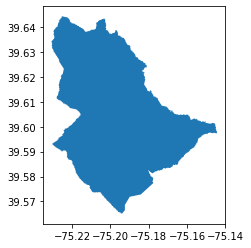

In [79]:
x = explode_fa_gdf[1:2]
x
x.plot()

In [80]:
# Muddy Run 
#explode_fa_gdf_valid = explode_fa_gdf[explode_fa_gdf['geom'].type != 'LineString']
#explode_fa_gdf_valid
#MR_gdf = explode_fa_gdf_valid.explode()

In [81]:
explode_fa_gdf.to_file(project_path / Path('stage2/Protected_Lands/muddyrun.geojson'), driver="GeoJSON")
MR_json = json.load(open(project_path / Path('stage2/Protected_Lands/muddyrun.geojson')))

## WCPA

In [82]:
wcpa_gdf_invalid = wcpa_gdf[wcpa_gdf.is_valid == False]
invalid_ind = wcpa_gdf_invalid.index.to_list()
#wcpa_gdf_invalid

In [83]:
for i in invalid_ind:
    geom = wcpa_gdf.loc[i]['geometry']
    valid = make_valid(geom)
    wcpa_gdf.at[i,'geometry'] = valid

# Save geometries to geojsons

In [84]:
# JSON cannot interpret categorical datatype. Convert all categorical to object
cluster_gdf = cluster_gdf.reset_index()
cluster_gdf = cluster_gdf.astype({'name': object, 'labels': object})

In [85]:
# Subset wcpa into 5 separate files bc api capacity is 5000 calls/day
wcpa_1 = wcpa_gdf[0:4999]
wcpa_2 = wcpa_gdf[4999:9999]
wcpa_3 = wcpa_gdf[9999:14999]
wcpa_4 = wcpa_gdf[14999:19999]
wcpa_5 = wcpa_gdf[19999:22138]

In [106]:
wcpa_1.to_file(project_path / Path('stage2/Protected_Lands/wcpa1.geojson'), driver="GeoJSON")
wcpa1_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa1.geojson')))

wcpa_2.to_file(project_path / Path('stage2/Protected_Lands/wcpa2.geojson'), driver="GeoJSON")
wcpa2_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa2.geojson')))

wcpa_3.to_file(project_path / Path('stage2/Protected_Lands/wcpa3.geojson'), driver="GeoJSON")
wcpa3_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa3.geojson')))

wcpa_4.to_file(project_path / Path('stage2/Protected_Lands/wcpa4.geojson'), driver="GeoJSON")
wcpa4_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa4.geojson')))

wcpa_5.to_file(project_path / Path('stage2/Protected_Lands/wcpa5.geojson'), driver="GeoJSON")
wcpa5_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa5.geojson')))

C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Ind

In [86]:
fielddoc_gdf.to_file(project_path / Path('stage2/private/fielddoc.geojson'), driver="GeoJSON")
fd_json = json.load(open(project_path / Path('stage2/private/fielddoc.geojson')))

cluster_gdf.to_file(project_path / Path('stage2/Protected_Lands/cluster.geojson'), driver="GeoJSON")
cluster_json = json.load(open(project_path / Path('stage2/Protected_Lands/cluster.geojson')))

focusarea_gdf.to_file(project_path / Path('stage2/Protected_Lands/focusarea.geojson'), driver="GeoJSON")
focusarea_json = json.load(open(project_path / Path('stage2/Protected_Lands/focusarea.geojson')))

huc12_gdf.to_file(project_path / Path('stage2/Protected_Lands/huc12.geojson'), driver="GeoJSON")
huc12_json = json.load(open(project_path / Path('stage2/Protected_Lands/huc12.geojson')))

C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Analyze land use in MMW

In [87]:
staging_api_key = '92e98c45471a525608b98885f43468d68d471dca'

In [88]:
# Create an API user
mmw_run = ModelMyWatershedAPI(api_key=staging_api_key, use_staging=True)

## Get natural land function

In [90]:
def get_3030(geojson):
    fa_3030_dict = {'name':[],
                    'mmw_area_m2': [],
                    'forest_area_m2': [],
                    'natural_area_m2': [],
                    'perc_forest': [],
                    'perc_natural': [],
                    'area_ac': []}
    

    forest_lu = [41, 42, 43]

    # Include open water, forest, shrub/scrub, grassland/herbaceous, and wetlands as "natural"
    natural_lu = [11, 41, 42, 43, 52, 71, 90, 95]
    
    for item in geojson['features']:
        if 'practice_id' in geojson['features'][0]['properties']:
            name = item['properties']['practice_id']
            area = "NaN"
            
        if 'OBJECTID' in geojson['features'][0]['properties']:
            name = item['properties']['OBJECTID']
            area = item['properties']['gis_acres']                                 
        
        if 'area_acres' in geojson['features'][0]['properties']:
            name = item['properties']['name']
            area = item['properties']['area_acres']
            
        if 'acres' in geojson['features'][0]['properties']:
            name = item['properties']['name']
            area = item['properties']['acres']
            
        else:
            name = item['properties']['name']
            area = 'NaN'
        
        try:
            item_lu = mmw_run.run_mmw_job(
                mmw_run.land_endpoint.format("2019_2019"),
                name,
                item['geometry'])

            item_lu_df = pd.DataFrame().from_dict(item_lu['result_response']['result']['survey']['categories'])
            
            total_area_m2 = item_lu_df['area'].sum()

            forest_df = item_lu_df[item_lu_df['nlcd'].isin(forest_lu)]
            forest_m2 = forest_df['area'].sum()

            natural_df = item_lu_df[item_lu_df['nlcd'].isin(natural_lu)]
            natural_m2 = natural_df['area'].sum()

            perc_forest = forest_m2/total_area_m2 * 100
            perc_natural = natural_m2/total_area_m2 * 100

            fa_3030_dict['name'].append(name)
            fa_3030_dict['mmw_area_m2'].append(total_area_m2)
            fa_3030_dict['forest_area_m2'].append(forest_m2)
            fa_3030_dict['natural_area_m2'].append(natural_m2)
            fa_3030_dict['area_ac'].append(area)
            fa_3030_dict['perc_forest'].append(perc_forest)
            fa_3030_dict['perc_natural'].append(perc_natural)

            print(f'Finished: {name}')
            
        except KeyError:
            print(f'***SKIPPED: {name}***')
    
    if name != 'Muddy Run':
        fa_3030_df = pd.DataFrame().from_dict(fa_3030_dict)
        return(fa_3030_df)
    
    else:
        fa_3030_df = pd.DataFrame().from_dict(fa_3030_dict)

        total_area_m2 = fa_3030_df['mmw_area_m2'].sum()
        natural_m2 = fa_3030_df['natural_area_m2'].sum()
        forest_m2 = fa_3030_df['forest_area_m2'].sum()
        
        perc_forest = forest_m2/total_area_m2 * 100
        perc_natural = natural_m2/total_area_m2 * 100
        
        df = pd.DataFrame({'name': ['Muddy Run'],
                           'mmw_area_m2': [total_area_m2],
                           'forest_area_m2': [forest_m2],
                           'natural_area_m2': [natural_m2],
                           'area_ac': [area],
                           'perc_forest': [perc_forest],
                           'perc_natural': [perc_natural]})
                           
        return(df)

## Clusters

In [77]:
cluster_lu_df = get_3030(cluster_json)

Finished: Poconos and Kittatinny
Finished: Middle Schuylkill
Finished: Brandywine and Christina
Finished: New Jersey Highlands
Finished: Schuylkill Highlands
Finished: Upstream Suburban Philadelphia
Finished: Kirkwood Cohansey Aquifer
Finished: Upper Lehigh


In [26]:
cluster_lu_df.to_parquet('cluster_naturalland.parquet', index=True, engine='pyarrow')

## Focus areas

In [65]:
fa_lu_df = get_3030(focusarea_json)

Muddy Run skipped


In [66]:
mr_fa_lu_df = get_3030(MR_json)

In [71]:
all_fa_lu_df = fa_lu_df.append(mr_fa_lu_df, ignore_index=True)

C:\Users\clulay\AppData\Local\Temp\ipykernel_134768\1472261897.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_fa_lu_df = fa_lu_df.append(mr_fa_lu_df, ignore_index=True)


In [72]:
all_fa_lu_df.to_parquet('focusarea_naturalland.parquet', index=True, engine='pyarrow')

## FieldDoc

In [34]:
fd_lu_df = get_3030(fd_json)

Finished: 5301
Finished: 5302
Finished: 5337
Finished: 5431
Finished: 5436
Finished: 5438
Finished: 5518
Finished: 13944
Finished: 14046
Finished: 14071
Finished: 14098
Finished: 14099
Finished: 14155
Finished: 14230
Finished: 14231
Finished: 41675
Finished: 42228
Finished: 42237
Finished: 42238
Finished: 42239
Finished: 42354
Finished: 42368
Finished: 42491
Finished: 42492
Finished: 42778
Finished: 42779
Finished: 44278
Finished: 44282
Finished: 44291
Finished: 44293
Finished: 44294
Finished: 44295
Finished: 44296
Finished: 44369
Finished: 44497
Finished: 48806
Finished: 49117
Finished: 49182
Finished: 49183
Finished: 49984
Finished: 49985
Finished: 51275
Finished: 51282
Finished: 51515
Finished: 51708
Finished: 51709
Finished: 51713
Finished: 51716
Finished: 51717
Finished: 51718
Finished: 51719
***SKIPPED: 51721***
Finished: 51722
Finished: 51724
Finished: 51729
Finished: 51736
Finished: 51737
Finished: 51742
Finished: 51743
Finished: 51745
Finished: 51751
Finished: 51752
Finished: 

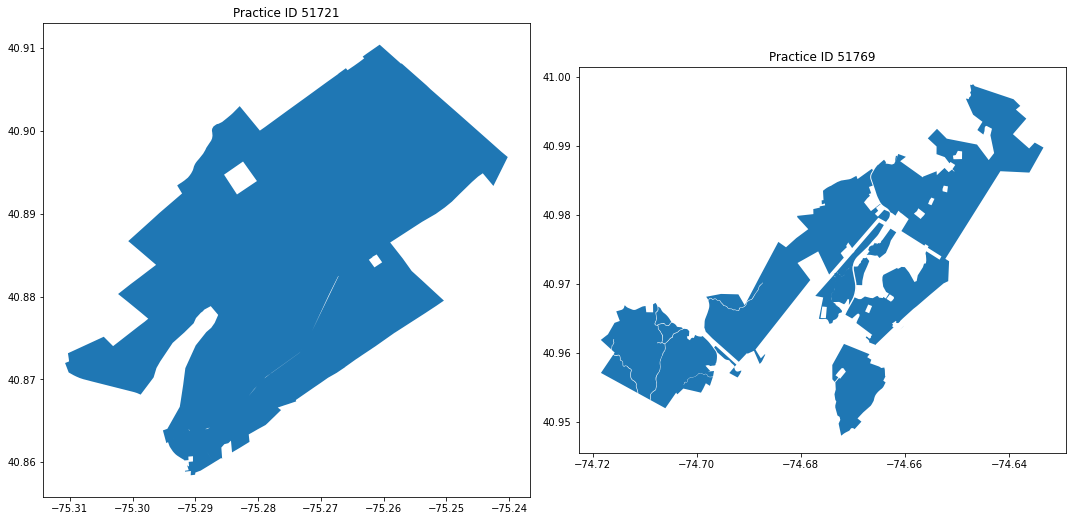

In [61]:
# Practice ID 51721 and 51769 were skipped 
x = fielddoc_gdf[fielddoc_gdf['practice_id']==51721]
y = fielddoc_gdf[fielddoc_gdf['practice_id']==51769]

fig, axes = plt.subplots(1,2, figsize=(15,15))

x.plot(ax=axes[0])
y.plot(ax=axes[1])

axes[0].set_title("Practice ID 51721")
axes[1].set_title("Practice ID 51769")

plt.tight_layout()

In [36]:
fd_lu_df.to_parquet('fd_naturalland.parquet', index=True, engine='pyarrow')

## WeConservePA

In [126]:
#wcpa1_lu_df = get_3030(wcpa1_json)
#wcpa2_lu_df = get_3030(wcpa2_json)
#wcpa3_lu_df = get_3030(wcpa3_json)
#wcpa4_lu_df = get_3030(wcpa4_json)
#wcpa5_lu_df = get_3030(wcpa5_json)

In [127]:
#wcpa1_lu_df.to_parquet('wcpa1_naturalland.parquet', index=True, engine='pyarrow')
#wcpa2_lu_df.to_parquet('wcpa2_naturalland.parquet', index=True, engine='pyarrow')
#wcpa3_lu_df.to_parquet('wcpa3_naturalland.parquet', index=True, engine='pyarrow')
#wcpa4_lu_df.to_parquet('wcpa4_naturalland.parquet', index=True, engine='pyarrow')
#wcpa5_lu_df.to_parquet('wcpa5_naturalland.parquet', index=True, engine='pyarrow')

### Skipped WCPA Projects

#### List of skipped oids

In [25]:
wcpa_skipped = [54,
            309,
            714,
            750,
            775,
            826,
            1032,
            1747,
            2162,
            2328,
            2360,
            2993,
            3071,
            3081,
            4194,
            4370,
            4582,
            4692,
            4693,
            4694,
            4713,
            4714,
            4715,
            4716,
            4717,
            4718,
            4719,
            4720,
            4721,
            4730,
            4731,
            4732,
            4733,
            4734,
            4752,
            4753,
            4754,
            4821,
            4830,
            4831,
            4832,
            4833,
            4834,
            4835,
            4838,
            4839,
            4840,
            4841,
            4842,
            4843,
            4844,
            4845,
            4846,
            4847,
            4848,
            4849,
            4920,
            4921,
            4922,
            4959,
            4960,
            4994,
            5272,
            5273,
            5274,
            5275,
            5278,
            5280,
            5281,
            5303,
            5307,
            5308,
            5317,
            5396,
            5478,
            5587,
            5850,
            5977,
            6048,
            6185,
            6271,
            6291,
            6843,
            8188,
            8189,
            8190,
            8191,
            8192,
            8193,
            8194,
            8195,
            8196,
            8197,
            8198,
            8199,
            8200,
            8201,
            8202,
            8203,
            8204,
            8205,
            8206,
            8207,
            8208,
            8209,
            8210,
            8211,
            8212,
            8213,
            8214,
            8215,
            8216,
            8217,
            8218,
            8219,
            8220,
            8221,
            8222,
            8223,
            8224,
            8225,
            8226,
            8227,
            8228,
            8229,
            8230,
            8231,
            8232,
            8233,
            8234,
            8235,
            8236,
            8237,
            8238,
            8239,
            8240,
            8241,
            8242,
            8243,
            8244,
            8245,
            8246,
            8247,
            8248,
            8249,
            8464,
            8934,
            8936,
            8937,
            8950,
            8957,
            8986,
            8987,
            9020,
            9026,
            9034,
            9039,
            9083,
            9088,
            9092,
            9109,
            9180,
            9219,
            9221,
            9249,
            9255,
            9293,
            9322,
            9340,
            9365,
            9429,
            9523,
            9540,
            9573,
            9652,
            9724,
            9726,
            9750,
            9751,
            9753,
            9807,
            9819,
            9918,
            9939,
            9940,
            9941,
            9942,
            9943,
            9944,
            9955,
            10002,
            10026,
            10046,
            10049,
            10050,
            10051,
            10052,
            10053,
            10054,
            10055,
            10056,
            10057,
            10058,
            10059,
            10060,
            10061,
            10062,
            10063,
            10064,
            10065,
            10066,
            10067,
            10068,
            10069,
            10137,
            10175,
            10260,
            10411,
            10458,
            10543,
            10787,
            10795,
            10812,
            10877,
            10917,
            10922,
            10923,
            10924,
            10930,
            10977,
            11221,
            11222,
            11270,
            11272,
            11289,
            11304,
            11310,
            11397,
            11403,
            11421,
            11428,
            11448,
            11523,
            11528,
            11535,
            11542,
            11546,
            11579,
            11834,
            11868,
            11933,
            11969,
            12179,
            12255,
            12303,
            12313,
            12532,
            12542,
            12543,
            12569,
            12574,
            12660,
            12661,
            12662,
            12680,
            12743,
            12995,
            12996,
            13142,
            13170,
            13181,
            13357,
            13417,
            13548,
            13673,
            13697,
            13853,
            13871,
            13894,
            13957,
            14026,
            14323,
            14352,
            14357,
            14438,
            14578,
            14594,
            14598,
            14601,
            14626,
            14634,
            14645,
            14649,
            14660,
            14681,
            14684,
            14694,
            14696,
            14698,
            14702,
            14713,
            14714,
            14737,
            14742,
            14754,
            14770,
            14774,
            14782,
            14783,
            14784,
            14785,
            14786,
            14787,
            14788,
            14789,
            14790,
            14799,
            14800,
            14801,
            14802,
            14803,
            14813,
            14821,
            14822,
            14823,
            14832,
            14841,
            14876,
            14890,
            14899,
            14900,
            14901,
            14902,
            14903,
            14904,
            14907,
            14908,
            14909,
            14910,
            14911,
            14912,
            14913,
            14914,
            14915,
            14916,
            14917,
            14918,
            14925,
            14928,
            14934,
            14947,
            14957,
            14958,
            14963,
            14972,
            14980,
            14985,
            14987,
            14989,
            14990,
            14991,
            14992,
            15005,
            15010,
            15020,
            15110,
            15275,
            15322,
            15337,
            15338,
            15396,
            15397,
            15414,
            15421,
            15477,
            15487,
            15574,
            15654,
            15656,
            15784,
            16380,
            16397,
            16464,
            16487,
            16595,
            16659,
            16778,
            16783,
            16791,
            16800,
            16817,
            16832,
            16844,
            16845,
            16846,
            16862,
            16897,
            16903,
            16907,
            16918,
            16920,
            16959,
            16976,
            16994,
            17000,
            17013,
            17036,
            17080,
            17081,
            17110,
            17121,
            17222,
            17229,
            17236,
            17276,
            17297,
            17342,
            17402,
            17537,
            17540,
            17543,
            17559,
            17564,
            17566,
            17567,
            17828,
            17841,
            17925,
            18027,
            18029,
            18030,
            18031,
            18032,
            18033,
            18036,
            18038,
            18040,
            18041,
            18042,
            18043,
            18045,
            18046,
            18048,
            18049,
            18051,
            18052,
            18053,
            18054,
            18055,
            18056,
            18058,
            18060,
            18062,
            18063,
            18064,
            18065,
            18067,
            18068,
            18069,
            18071,
            18072,
            18073,
            18075,
            18077,
            18078,
            18079,
            18080,
            18089,
            18093,
            18095,
            18320,
            18345,
            18735,
            19074,
            19404,
            19405,
            19406,
            19409,
            19411,
            19412,
            19413,
            19415,
            19416,
            19417,
            19418,
            19419,
            19422,
            19423,
            19424,
            19425,
            19426,
            19427,
            19428,
            19429,
            19432,
            19433,
            19434,
            19436,
            19437,
            19438,
            19439,
            19441,
            19470,
            19924,
            19933,
            19963,
            19968,
            19969,
            19972,
            20085,
            20167,
            20175,
            20177,
            20184,
            20218,
            20404,
            20408,
            20413,
            20418,
            20419,
            20426,
            20434,
            20438,
            20455,
            20457,
            20462,
            20469,
            20470,
            20482,
            20483,
            20484,
            20485,
            20501,
            20502,
            20503,
            20504,
            20507,
            20512,
            20517,
            20525,
            20526,
            20528,
            20529,
            20547,
            20565,
            20616,
            20670,
            20672,
            20708,
            20709,
            20735,
            20736,
            20742,
            20754,
            20762,
            20785,
            20800,
            20841,
            20852,
            20855,
            20892,
            20896,
            20917,
            20920,
            20921,
            20922,
            20929,
            20930,
            20964,
            20970,
            20971,
            20993,
            21023,
            21058,
            21079,
            21080,
            21154,
            21181,
            21190,
            21201,
            21216,
            21217,
            21219,
            21246,
            21252,
            21325,
            21368,
            21427,
            21428,
            21502,
            21606,
            21610,
            21633,
            21664,
            21669,
            21689,
            21696,
            21718,
            21742,
            21743,
            21782,
            21793,
            21795,
            21801,
            21807,
            21808,
            21810,
            21817,
            21818,
            21819,
            21820,
            21821,
            21823,
            21826,
            21832,
            21833,
            21834,
            21835,
            21836,
            21837,
            21838,
            21839,
            21840,
            21841,
            21844,
            21845,
            21846,
            21847,
            21848,
            21849,
            21850,
            21851,
            21852,
            21853,
            21854,
            21855,
            21858,
            21859,
            21860,
            21861,
            21862,
            21863,
            21864,
            21865,
            21866,
            21867,
            21870,
            21871,
            21872,
            21873,
            21874,
            21875,
            21876,
            21877,
            21878,
            21879,
            21880,
            21881,
            21882,
            21883,
            21888,
            21889,
            21890,
            21891,
            21892,
            21893,
            21894,
            21895,
            21896,
            21897,
            21898,
            21899,
            21900,
            21901,
            21902,
            21903,
            21906,
            21907,
            21913,
            21914,
            21915,
            21916,
            21919,
            21920,
            21921,
            21922,
            21925,
            21926,
            21927,
            21928,
            21933,
            21934,
            21937,
            21938,
            21939,
            21940,
            21941,
            21942,
            21945,
            21946,
            21947,
            21948,
            21949,
            21950,
            21953,
            21954,
            21957,
            21960,
            21961,
            21970,
            21971,
            21972,
            21973,
            21976,
            21977,
            21978,
            21979,
            21980,
            21981,
            21982,
            21983,
            21986,
            21987,
            21988,
            21989,
            21992,
            21993,
            21996,
            21997,
            21998,
            21999,
            22000,
            22001,
            22002,
            22003,
            22006,
            22007,
            22010,
            22011,
            22014,
            22015,
            22020,
            22021,
            22022,
            22023,
            22024]


#### Address skipped oids

In [26]:
subwcpa_gdf = wcpa_gdf[wcpa_gdf['OBJECTID'].isin(wcpa_skipped)]

##### Skipped oids < 5000

In [27]:
subwcpa_gdf_5000 = subwcpa_gdf[subwcpa_gdf['OBJECTID'] < 5000]

In [28]:
subwcpa_gdf_5000.to_file(project_path / Path('stage2/Protected_Lands/subwcpa1.geojson'), driver="GeoJSON")
subwcpa_gdf_json1 = json.load(open(project_path / Path('stage2/Protected_Lands/subwcpa1.geojson')))

C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [31]:
# WCPA1 (OID 0 to 5000) was originally saved to geojson before validating the geometries.
# Using the updated wcpa_gdf with validated geometries resolves most of the skipped oids
subwcpa_lu1 = get_3030(subwcpa_gdf_json1)

Finished: 54
Finished: 309
Finished: 714
Finished: 750
Finished: 775
Finished: 826
Finished: 1032
Finished: 1747
Finished: 2162
Finished: 2328
Finished: 2360
***SKIPPED: 2993***
Finished: 3071
Finished: 3081
Finished: 4194
***SKIPPED: 4370***
***SKIPPED: 4582***
Finished: 4692
Finished: 4693
Finished: 4694
Finished: 4713
Finished: 4714
Finished: 4715
Finished: 4716
Finished: 4717
Finished: 4718
Finished: 4719
Finished: 4720
Finished: 4721
Finished: 4730
Finished: 4731
Finished: 4732
Finished: 4733
Finished: 4734
Finished: 4752
Finished: 4753
Finished: 4754
Finished: 4821
Finished: 4830
Finished: 4831
Finished: 4832
Finished: 4833
Finished: 4834
Finished: 4835
Finished: 4838
Finished: 4839
Finished: 4840
Finished: 4841
Finished: 4842
Finished: 4843
Finished: 4844
Finished: 4845
Finished: 4846
Finished: 4847
Finished: 4848
Finished: 4849
Finished: 4920
Finished: 4921
Finished: 4922
Finished: 4959
Finished: 4960
Finished: 4994


##### Remaining skipped oids

In [32]:
# Append the skipped oids from the validated 0 to 5000 oids
wcpa_skipped2 = [i for i in wcpa_skipped if i >= 5000]
wcpa_skipped2.append(2993)
wcpa_skipped2.append(4370)
wcpa_skipped2.append(4582)

In [33]:
# Subset wcpa to the new skipped values and explode to separate out any multipart geometries
subwcpa_gdf2 = subwcpa_gdf[subwcpa_gdf['OBJECTID'].isin(wcpa_skipped2)]
#subwcpa_gdf2[subwcpa_gdf2['OBJECTID']==4582].plot()

In [34]:
# Identify area of skipped oids
subwcpa_gdf2 = subwcpa_gdf2.to_crs('ESRI:102003')
subwcpa_gdf2.geometry.area.sum()/4046 

6018.576549939511

~ 6000 acres skipped which is a fairly substantial area

In [35]:
subwcpa_gdf2_explode = subwcpa_gdf2.explode()
subwcpa_gdf2_explode = subwcpa_gdf2_explode.reset_index()

C:\Users\clulay\AppData\Local\Temp\ipykernel_126308\1634541892.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  subwcpa_gdf2_explode = subwcpa_gdf2.explode()


In [36]:
subwcpa_gdf2_explode = subwcpa_gdf2_explode.to_crs(epsg=4326)

subwcpa_gdf2_explode.to_file(project_path / Path('stage2/Protected_Lands/subwcpa2.geojson'), driver="GeoJSON")
subwcpa_gdf2_json = json.load(open(project_path / Path('stage2/Protected_Lands/subwcpa2.geojson')))

C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [38]:
subwcpa_lu2 = get_3030(subwcpa_gdf2_json)

***SKIPPED: 2993***
***SKIPPED: 4370***
***SKIPPED: 4582***
***SKIPPED: 5272***
***SKIPPED: 5273***
***SKIPPED: 5274***
***SKIPPED: 5275***
***SKIPPED: 5278***
***SKIPPED: 5280***
***SKIPPED: 5281***
***SKIPPED: 5303***
***SKIPPED: 5307***
***SKIPPED: 5308***
***SKIPPED: 5317***
***SKIPPED: 5396***
***SKIPPED: 5478***
***SKIPPED: 5587***
***SKIPPED: 5850***
***SKIPPED: 5977***
***SKIPPED: 6048***
***SKIPPED: 6185***
***SKIPPED: 6271***
***SKIPPED: 6291***
***SKIPPED: 6843***
Finished: 8188
Finished: 8188
Finished: 8189
Finished: 8190
Finished: 8191
Finished: 8192
Finished: 8193
Finished: 8194
Finished: 8194
Finished: 8194
Finished: 8195
Finished: 8196
Finished: 8197
Finished: 8198
Finished: 8199
Finished: 8200
Finished: 8200
Finished: 8201
Finished: 8202
Finished: 8203
Finished: 8204
Finished: 8204
Finished: 8205
Finished: 8205
Finished: 8206
Finished: 8207
Finished: 8207
Finished: 8207
Finished: 8208
Finished: 8209
Finished: 8210
Finished: 8210
Finished: 8211
Finished: 8212
Finished: 

In [39]:
subwcpa_lu2

,name,level,mmw_area_m2,forest_area_m2,natural_area_m2,perc_forest,perc_natural,area_ac
0,8188,0,21534.228191,0.000000,0.000000,0.000000,0.000000,9.080247
1,8188,1,15253.410703,0.000000,0.000000,0.000000,0.000000,9.080247
2,8189,0,191113.780977,79855.054023,80752.301821,41.784038,42.253521,47.409334
3,8190,0,8972.640835,2691.792251,8972.640835,30.000000,100.000000,2.503757
4,8191,0,184834.885648,93314.699551,93314.699551,50.485437,50.485437,46.680066
...,...,...,...,...,...,...,...,...
188,14990,0,897.224221,0.000000,0.000000,0.000000,0.000000,0.177312
189,14991,0,897.224210,0.000000,0.000000,0.000000,0.000000,0.378683
190,16595,0,897.245279,0.000000,0.000000,0.000000,0.000000,0.164319
191,17559,0,897.199956,0.000000,0.000000,0.000000,0.000000,0.184638


In [40]:
subwcpa_lu2_sum = subwcpa_lu2.groupby('name').sum()
subwcpa_lu2_sum = subwcpa_lu2_sum.drop(labels=['perc_forest','perc_natural','area_ac'], axis=1)
subwcpa_lu2_sum

,level,mmw_area_m2,forest_area_m2,natural_area_m2
name,,,,
8188,1,36787.638894,0.000000,0.000000
8189,0,191113.780977,79855.054023,80752.301821
8190,0,8972.640835,2691.792251,8972.640835
8191,0,184834.885648,93314.699551,93314.699551
8192,0,640650.272432,344551.407022,360702.254226
...,...,...,...,...
14990,0,897.224221,0.000000,0.000000
14991,0,897.224210,0.000000,0.000000
16595,0,897.245279,0.000000,0.000000


In [92]:
subwcpa_lu2_sum = subwcpa_lu2_sum[subwcpa_lu2_sum['mmw_area_m2']/4046.86 > 0.5]

In [93]:
remove_list = subwcpa_lu2_sum.index.to_list()
wcpa_skipped3 = [i for i in wcpa_skipped2 if i not in remove_list]

In [94]:
# Identify area of skipped oids
subwcpa_gdf3 = subwcpa_gdf[subwcpa_gdf['OBJECTID'].isin(wcpa_skipped3)]
subwcpa_gdf3 = subwcpa_gdf3.to_crs('ESRI:102003')
subwcpa_gdf3.geometry.area.sum()/4046 

65.01002855946909

~65 acres remaining that have not been accounted for in terms of WCPA natural and forested land

### Save to parquet

In [95]:
# Merge subwcpa_lu1 and subwcpa_lu2
skipped_wcpa_df = pd.concat([subwcpa_lu1, subwcpa_lu2])
skipped_wcpa_df = skipped_wcpa_df.drop('level', axis=1)

In [96]:
# Save to parquet
skipped_wcpa_df.to_parquet('skipped_wcpa.parquet', index=True, engine='pyarrow')

## HUC 12s

In [91]:
huc12_lu = get_3030(huc12_json)

Finished: 020402031005
Finished: 020401060204
Finished: 020403030603
Finished: 020403030604
Finished: 020403030203
Finished: 020403020107
Finished: 020402030406
Finished: 020402070401
Finished: 020401040903
Finished: 020401030302
Finished: 020403010503
Finished: 020403030502
Finished: 020401040501
Finished: 020401040503
Finished: 020402010101
Finished: 020402010102
Finished: 020403010604
Finished: 020403020101
Finished: 020401050203
Finished: 020401010502
Finished: 020401060806
Finished: 020403030204
Finished: 020403010608
Finished: 020401060802
Finished: 020402030306
Finished: 020401060805
Finished: 020401060201
Finished: 020402060302
Finished: 020402060103
Finished: 020402060404
Finished: 020403040201
Finished: 020402030610
Finished: 020402030901
Finished: 020401060703
Finished: 020401030202
Finished: 020403020103
Finished: 020401030102
Finished: 020403040203
Finished: 020401050202
Finished: 020401040703
Finished: 020401060804
Finished: 020401050102
Finished: 020401010605
Finished: 0

In [99]:
huc12_lu.to_parquet('huc12_naturallands.parquet', index=False, engine='pyarrow')